# Parametric Compilation on QCS

In this notebook, we will walk through how to use **Parametric Compilation** to efficiently execute a collection of Quil programs on the QPU. Although we use a toy example in this notebook, the principles here can be extended to rapidly iterate through real-world applications such as optimizing a variational quantum algorithm (as we will do in the **Max-Cut QAOA** notebook).

**NOTE**: This notebook depends on `pyquil >= 3.0.0` and `matplotlib`, which come preinstalled in QCS JupyterHub.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pyquil import get_qc, Program
from pyquil.gates import MEASURE, RX

## Get Started

Before running on the QPU, users must book a block of time on a QPU using [QCS](https://qcs.rigetti.com). During your reservation, you must then set up the `QuantumComputer` object, which we do in the following cell.

**NOTE**: When running this notebook, you will need to edit the `quantum_processor` and `qubits` entries in the following cell to match whatever QPU lattice you end up booking. And remember that this code will only work from within QCS JupyterHub!

In [2]:
quantum_processor = 'Aspen-11'  # edit as necessary
qpu = get_qc(quantum_processor)
qubit = qpu.quantum_processor.qubits()[-1]  # edit as necessary
print(f'All qubits on {quantum_processor}: {qpu.quantum_processor.qubits()}')

All qubits on Aspen-1-8Q-B: [1, 10, 11, 13, 14, 15, 16, 17]

Selected qubit: 17


## Declare Parameters

Users can now define regions of the classical shared memory (using the `DECLARE` syntax) that can then be used in quantum gates. Declared parameters take a name, type, and length. For float-valued parameters, such as the argument for gates like `RX`/`RY`/`RZ`, we use the `REAL` type. When declaring the block of memory for reading out the measurement results of the program, we use the `BIT` type, as these results are either 0 or 1. In the next cell we initialize a `Program` that has two declared parameters.

In [3]:
program = Program()
theta = program.declare('theta', 'REAL', 1)
ro = program.declare('ro', 'BIT', 1)

## Define Gates

Next we will add an `RX` gate that uses the declared "theta" parameter. The argument provided to the `RX` gate says how much we want to rotate the qubit state around the _x_-axis of the Bloch sphere. The argument is interpreted as an angle in radians—0 means no rotation and 2π means a full rotation around the axis. After the `RX` gate, we then add a `MEASURE` that uses the declared "ro" parameter. This gate measures the state of a single qubit, putting a bit value in the readout register (provided to the gate as the "ro" parameter). Finally, we specify the number of shots we want to run per program. The program may not produce deterministic outcomes, so we accumulate statistics with many repetitions (which we call shots).

In [4]:
program.inst(RX(theta, qubit))
program.inst(MEASURE(qubit, ro))
program.wrap_in_numshots_loop(1000)

## Compile to Parametric Binary

After building our Quil program, we then perform parametric compilation to produce binaries that will be loaded onto the instruments that control the QPU. The `compile` method has two stages: `quil_to_native_quil` and `native_quil_to_binary`.

In general, programs written in Quil are not directly implementable on our devices. Fortunately, due to the underlying mathematical nature of quantum programs, arbitrary Quil can be compiled into a much smaller set of quantum instructions, referred to as **native Quil**. This stage of compilation is performed using `quilc`, which is also part of the downloadable [Forest SDK](https://www.rigetti.com/forest).

The second stage of compilation takes native Quil (which for our architecture, is composed of only the `CZ`, `RX`, and `RZ` gates plus `MEASURE`) and converts it into a collection of instrument binaries. For programs that have declared parameters, we refer to these binaries as parametric binaries, as the values (arguments) for their parameters are set at **run-time** rather than **compile-time**.

In [5]:
binary = qpu.compile(program)

## Execute on the QPU

Once we have our parametric binary, we are ready to run on the QPU. As you will see, we only have to compile once, and can rapidly iterate through many values of "theta". We begin by defining the range of angles that we want to sweep over. Then, we execute the parametric binary on the QPU, providing the "theta" argument at run-time using the `memory_map` keyword argument to the `run` method. The memory map is a dictionary with strings as keys and lists as values (remember the parameters have a size, so for our "theta" parameter we use a list of length 1). Finally, we average over the number of shots to produce a single excited state visibility value for each value of "theta".

In [6]:
sweep = np.linspace(start=0, stop=4 * np.pi, num=50)

visibilities = []
for angle in sweep:
    job_results = qpu.run(binary, memory_map={'theta': [angle]})
    visibilities.append(np.mean(job_results))

## Plot the Results

Lastly, we take the results from the various jobs and plot them as a function of "theta". We expect to see a sinusoidal curve that shows us moving around the Bloch sphere from the |0⟩ state to the |1⟩ state and back.

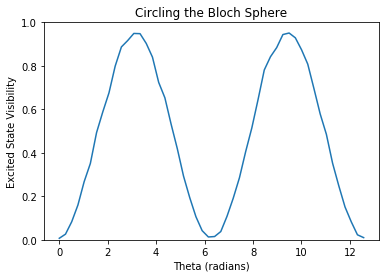

In [7]:
plt.plot(sweep, visibilities)
plt.ylim(0, 1)
plt.title('Circling the Bloch Sphere')
plt.ylabel('Excited State Visibility')
plt.xlabel('Theta (radians)')
plt.show()